In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import utm
import pandas as pd
import math
from matplotlib.pyplot import figure
from matplotlib import cm as CM
from matplotlib import mlab as ML

def searchfam(i, familias):
    if i.find("SYD8")>0: i=i.replace("SYD8", "")
    for k in familias:
        if i in k["integrantes"]: 
            return k
    return {"Familia":"none", "c1":0, "c2":0}

#Function to get bootstrap metrics
def bootit(lista):
    proms=[]
    if len(lista)<1000:
        for s in range(500):
            nl=random.choices(lista, k=len(lista))
            proms.append(np.mean(nl))
        return np.percentile(proms, 5), np.percentile(proms, 95)
    else:
        error_std=np.std(lista)/(len(lista)**0.5)
        return np.mean(lista)-1.96*error_std, np.mean(lista)+1.96*error_std
    

    
    
def distancia_fisica(a, b, information):
    x1=information[a]["utm_xy"][0]
    y1=information[a]["utm_xy"][1]
    x2=information[b]["utm_xy"][0]
    y2=information[b]["utm_xy"][1]
    return euclidean_dist((x1, y1), (x2, y2))

def distancia_np(a, b, information):
    a=information[a]["distance_np"]
    b=information[b]["distance_np"]
    return (a+b)/2.0



#Funciones de verosimilitud de panal
def euclidean_dist(a, b):
    d=0
    for i, j in zip(a, b):
        d+=(i-j)**2
    return d**0.5

def verif_atr(veros, atr):
    v2=veros
    flag=True
    ind=0
    for at in atr:
        if ind<len(atr)-1:
            if at not in v2: 
                flag=False
                v2[at]={}
            v2=v2[at]
            ind+=1
        else:
            if at not in v2: 
                flag=False
                v2[at]=0
    return veros, flag

def gradient(c1, c2, a):
    b=1-a
    tupi1=(tuple(int(c1[1:][i:i+2], 16)/255.0 for i in (0, 2, 4)))
    tupi2=(tuple(int(c2[1:][i:i+2], 16)/255.0 for i in (0, 2, 4)))
    return (tupi1[0]*a+tupi2[0]*b, tupi1[1]*a+tupi2[1]*b, tupi1[2]*a+tupi2[2]*b)

def set_val(veros, atr, res):
    ind=0
    v2=veros
    for at in atr:
        if ind<len(atr)-1:
            v2=v2[at]
        else: 
            v2[at]=res
        ind=ind+1
    return veros

def place(veros, atr):
    v2=veros
    for at in atr:
        v2=v2[at]
    return v2


def get_verosimilitud(p0, p1, s0, s1, v, lam1, lam2):
    p=(p0,p1)
    s=(s0,s1)
    prob=lam1*math.exp(-lam2*euclidean_dist(p,s))
    return v*prob+(1-v)*(1-prob)

def get_veros(lams1, lams2, lam1, lam2, nvisit, visit, xr, yr, fams):
    Z=[]
    index=len(xr)*len(fams)*lams2.index(lam2)+len(xr)*len(fams)*len(lams2)*lams1.index(lam1)
    for ix, iy in zip(xr, yr):
        z=1
        for familia in fams:
            if fams[familia]==1: z=z*visit[index]
            else: z=z*nvisit[index]
            index+=1
        Z.append(z**(1/len(fams)))
    return Z


def distancia_genetica1(a, b, distribution):
    distancia=0
    for alele in distribution:
        if a[alele]==b[alele]: distancia=distancia+(1/distribution[alele][a[alele]])
        
    return distancia

def distancia_genetica2(a, b, distribution):
    distancia=0
    for alele in distribution:
        if a[alele]==b[alele]: distancia+=1/float(len(distribution))
        
    return distancia

def distancia_genetica3(a, b, distribution):
    distancia=0
    tot=0
    tot2=0
    for alele in distribution:
        tot+=(1/distribution[alele][a[alele]])
        tot+=(1/distribution[alele][b[alele]])
        if a[alele]==b[alele]: tot2+=2*(1/distribution[alele][b[alele]])
    return tot2/float(tot)


def distancia_genetica4(a, b, distribution):
    P_A1_a1=1
    P_A2_a2=1
    N=269
    P_A2_a2_hermano_a2=1
    for alele in distribution:
        P_A1_a1=P_A1_a1*(distribution[alele][a[alele]])
        P_A2_a2=P_A2_a2*(distribution[alele][b[alele]])
        P_A2_a2_hermano_a2=P_A2_a2_hermano_a2*((1/2)*(int(a[alele]==b[alele]))+int(a[alele]!=b[alele])*(1/2)*(distribution[alele][b[alele]])/(1-distribution[alele][a[alele]]))
    P_A1_A2_distinta_mama=P_A1_a1*P_A2_a2
    P_A1_A2_misma_mama=P_A1_a1*P_A2_a2_hermano_a2
    return (1/(1+(N-1)*P_A1_A2_distinta_mama/P_A1_A2_misma_mama))
    
            
        
locations={"1 Belmore st. North parramatta": "Parramatta", "1 Oberon Cresc": "Gordon", 
           "20 Philip Rd Mona Vale": "Palmbeach", "25 Strickland Ave.": "Strickland", 
           "38 Park Ave Ashfield": "Asheville", "4 Goodlet St. Surry Hills": "Surry Hills", 
           "430 Mona Vale Rd.": "Stives", "67-71 Eton St Sutherland": "Sutherland", 
           "7th Fourth Avenue Jannali": "Jannali", "8 Treatts Rd": "Lindfield", 
           "92 Griffiths St. balgowlah": "Balgowlah ", "beauford Ave Ros parents": "Caringbah", 
           "Kate´s place Unit 6 2-4 Wood st. Manley": "Manley", "Ros House Woodland street": "Marrickville", 
           "Strickland Avenue 25": "Strickland", "UNISYD": "Camperdown", " 7 Cary St Leichhardt": "Leichhardt", 
           "131 Nelson Street, Anandale": "Anandale", "Bondi Junction": "Bondi Junction", 
           "Francisco (Surrey Hills)": "Surrey Hills", "Jannali": "Jannali", "Newtown Amelie": "Newtown", 
           "Paddington": "Paddington", "Ros' House": "Marrickville", "Ros's Brothers": "Marrickville 2", 
           "Ros's Parents": "Caringbah", "Ros´": "Marrickville sp", "Tanya's House": "Tanya", 
           "University": "University", "Vegetable Garden UNISYD": "Vegetable university", 
           "Mololahvalley":"Mololahvalley", "Beerwah2":"Beerwah2", 'Beerwah1':'Beerwah1', 'Saharafarms':'Saharafarms',
          'Beerwah3':'Beerwah3', "Vegetable university":"Vegetable university"}

coordenadas={"Marrickville":(-33.90468, 151.16067), "Surry Hills":(-33.88972, 151.20965),
             "Camperdown":(-33.88514, 151.18837), "Asheville":(-33.89428, 151.12279),
             "Balgowlah ":(-33.79207, 151.26724),"Manley":(-33.80352, 151.28617),"Jannali":(-34.01215, 151.07181),
             "Sutherland":(-34.03502, 151.05768), "Stives": (-33.70606, 151.18046),"Palmbeach":(-33.66858, 151.31378),
            "Lindfield":(-33.77102, 151.16314),"Gordon":(-33.75781, 151.15081),"Caringbah":(-34.06095, 151.11111), 
             "Parramatta":(-33.800766, 151.009321), "Strickland":(-33.778420, 151.171036)
            }


coordenadas2017={ "Vegetable university":(-33.88923, 151.19259), "Marrickville 2":(-33.90468, 151.16067),
             'Marrickville sp':(-33.89828, 151.16525), 'Bondi Junction': (-33.88877, 151.24145) ,
             'University': (-33.88514, 151.18837), 'Surrey Hills':(-33.88972, 151.20965),
             'Newtown': (-33.894944, 151.187083), 'Anandale': (-33.882977, 151.173809),
                 "Jannali":(-34.0212, 151.06618), 'Caringbah':(-34.06084, 151.11107),
                 'Marrickville':(-33.89828, 151.16525), "Leichhardt":(-33.884889, 151.156028),
                 "Paddington":(-33.881917, 151.180611), "Tanya":(-33.88425, 151.23336)
            }

distance_national_park={
    "Marrickville":17.5,"Surry Hills":20, "Camperdown":20, "Asheville":17.5,"Balgowlah ":11.3,"Manley":13.5,
            "Jannali":3.3,"Sutherland":5, "Stives": 0.1,"Palmbeach":3.4,"Lindfield":7.3,"Gordon":6.5,"Caringbah":1, 
    "Parramatta":10, "Strickland":7.3}

def to_xy(point):
    r=6371000
    phi_0 = 151.16067
    cos_phi_0 = math.cos(math.radians(phi_0))
    lam = point[0]
    phi = point[1]
    return (r * math.radians(lam) * cos_phi_0, r * math.radians(phi))


xaxis  = [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[0]  for l in coordenadas]
yaxis = [utm.from_latlon(coordenadas[l][0],coordenadas[l][1])[1] for l in coordenadas]
medy  =  np.mean(yaxis)
medx  =  np.mean(xaxis)

xaxis  = [to_xy((coordenadas[l][0],coordenadas[l][1]))[0]  for l in coordenadas]
yaxis = [to_xy((coordenadas[l][0],coordenadas[l][1]))[1] for l in coordenadas]
medy2  =  np.mean(yaxis)
medx2  =  np.mean(xaxis)

information={}
for k in coordenadas:
    information[k]={}
    information[k]["coordenadas"]=coordenadas[k]
    utm_val=utm.from_latlon(coordenadas[k][0], coordenadas[k][1])
    information[k]["utm_xy"]=((utm_val[0]-medx)/1000, (utm_val[1]-medy)/1000)
    
    xy_val=to_xy(coordenadas[k])
    information[k]["alt_xy"]=((xy_val[0]-medx2)/1000, (xy_val[1]-medy2)/1000)
    
    information[k]["distance_np"]=distance_national_park[k]
    
   


information2017={}
for k in coordenadas2017:
    information2017[k]={}
    information2017[k]["coordenadas"]=coordenadas2017[k]
    utm_val=utm.from_latlon(coordenadas2017[k][0], coordenadas2017[k][1])
    information2017[k]["utm_xy"]=((utm_val[0]-medx)/1000, (utm_val[1]-medy)/1000)
    
    xy_val=to_xy(coordenadas2017[k])
    information2017[k]["alt_xy"]=((xy_val[0]-medx2)/1000, (xy_val[1]-medy2)/1000)
    




Bad key "text.kerning_factor" on line 4 in
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Match with individual data

In [2]:
df=pd.read_csv("Aleles_clean.csv")

In [3]:
df["Site"]=[locations[i] for i in df["Collection site"]]

In [4]:
df_syd2018=df[df.Cluster=="PC2018"].copy()

In [5]:
f=open("output_colony.csv", "r")

a="A"
ind=0
familias=[]

while a!="":
    a=f.readline()
    if ind>0:
        nd={}
        b=a.split(",")
        if len(b)>2:
            nd["Familia"]=b[0]
            nd["c1"]=float(b[1])
            nd["c2"]=float(b[2])
            ind2=3
            parientes=[]
            while ind2<len(b):
                if b[ind2]!="" and b[ind2]!="\n": parientes.append(b[ind2].replace("\n", ""))
                ind2+=1
            nd["integrantes"]=parientes
            familias.append(nd)
    ind+=1

In [6]:
df_syd2018["Familia"]=[searchfam(i, familias)["Familia"] for i in df_syd2018["name0"]]
df_syd2018["C1_familia"]=[searchfam(i, familias)["c1"] for i in df_syd2018["name0"]]
df_syd2018["C2_familia"]=[searchfam(i, familias)["c2"] for i in df_syd2018["name0"]]

In [7]:
for k in range(len(familias)):
    familias[k]["sitios"]=[]
    for s in familias[k]["integrantes"]:
        sitio=df_syd2018.set_index("name1").loc[s]["Site"]
        familias[k]["sitios"].append(sitio)

In [8]:
for k in range(len(familias)):
    familias[k]["sitios_set"]=list(set(familias[k]["sitios"]))

In [9]:
k=80
k**(1+k/400)

192.17990943702895

In [10]:
%%time

sitios=list(set(df_syd2018["Site"]))

x = np.linspace(-20, 20, 40)
y = np.linspace(-30, 30, 60)

X, Y = np.meshgrid(x, y)
xr = X.ravel()
yr = Y.ravel()
pls=[np.min(xr), np.max(xr), np.min(yr), np.max(yr)]


#Old time CPU times: user 2min 4s, sys: 3.27 s, total: 2min 7s
#Wall time: 2min 13s
i=0
visit=[]
nvisit=[]

lams1=[0.1,  0.3,  0.5,  0.7,  0.9]
lams2=[(k**(1+k/400))/100 for k in range(1,80)]

for lam1 in lams1:
    for lam2 in lams2:
        print(str(lam1)+" - "+str(lam2), end="            \r")
        for ix, iy in zip(xr, yr):
            z=1
            for familia in information:
                atr=(ix, iy, information[familia]["utm_xy"][0], information[familia]["utm_xy"][1], 1, lam1, lam2)
                visit.append(get_verosimilitud(*atr))
                atr=(ix, iy, information[familia]["utm_xy"][0], information[familia]["utm_xy"][1], 0, lam1, lam2)
                nvisit.append(get_verosimilitud(*atr))



CPU times: user 2min 4s, sys: 2.7 s, total: 2min 7s
Wall time: 2min 53s


In [11]:
named_df=df_syd2018.set_index("name1")

In [12]:
import copy 

familias2=dict()
for k0 in range(0,10):
    k=k0/10.0
    print(k)
    lfams=[]
    for familia in familias:
        nd=dict(familia)
        nd["integrantes"]=copy.deepcopy(familia["integrantes"])
        quitar=[]
        for integrante in nd["integrantes"]:
            if named_df.loc[integrante]["Old prob"]<k: 
                quitar.append(integrante)
        for q in quitar:
            nd["integrantes"].remove(q)
            
        nd["sitios"]=[]
        for s in nd["integrantes"]:
            sitio=df_syd2018.set_index("name1").loc[s]["Site"]
            nd["sitios"].append(sitio)
        nd["sitios_set"]=list(set(nd["sitios"]))
        
        lfams.append(nd)
    familias2[k]=list(lfams)
        
        

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [13]:
familias2[0.9][50]

{'Familia': '51',
 'c1': 0.4919,
 'c2': 0.0488,
 'integrantes': ['160.18RG', '145.13'],
 'sitios': ['Balgowlah ', 'Marrickville'],
 'sitios_set': ['Marrickville', 'Balgowlah ']}

In [14]:
familias[50]

{'Familia': '51',
 'c1': 0.4919,
 'c2': 0.0488,
 'integrantes': ['160.18RG',
  '29.18',
  '159.13',
  '42.9',
  '126.3',
  '41.12',
  '107.18',
  '139.18',
  '103.2',
  '145.13'],
 'sitios': ['Balgowlah ',
  'Balgowlah ',
  'Marrickville',
  'Palmbeach',
  'Stives',
  'Asheville',
  'Balgowlah ',
  'Balgowlah ',
  'Camperdown',
  'Marrickville'],
 'sitios_set': ['Palmbeach',
  'Marrickville',
  'Balgowlah ',
  'Camperdown',
  'Stives',
  'Asheville']}

1


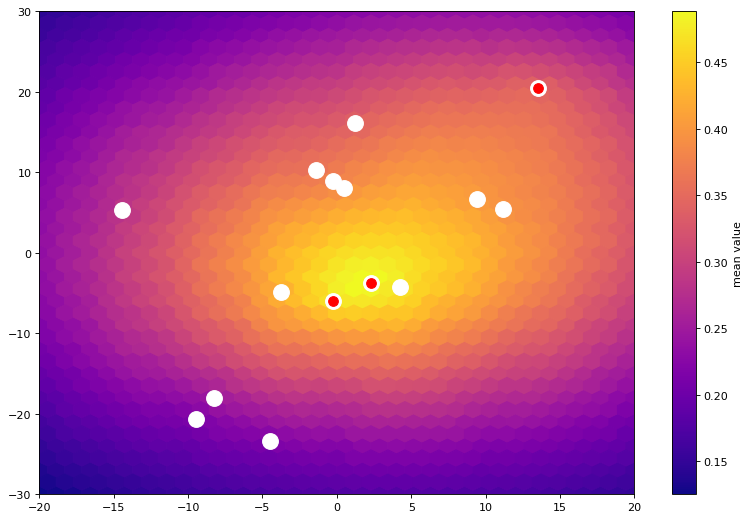

2


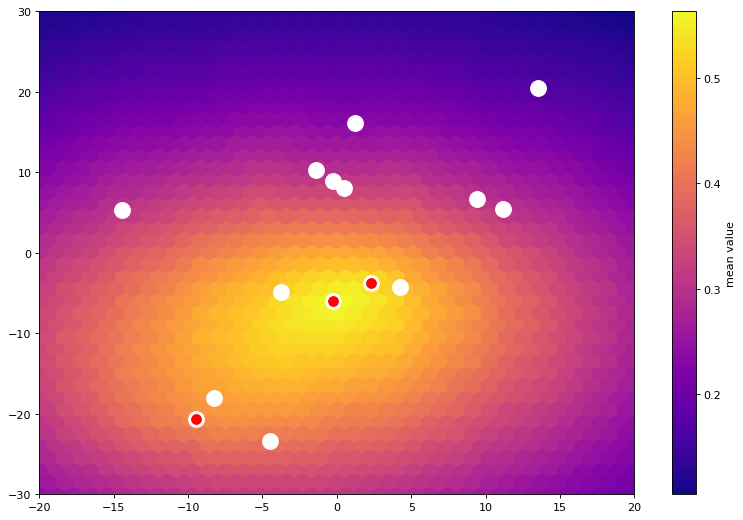

3


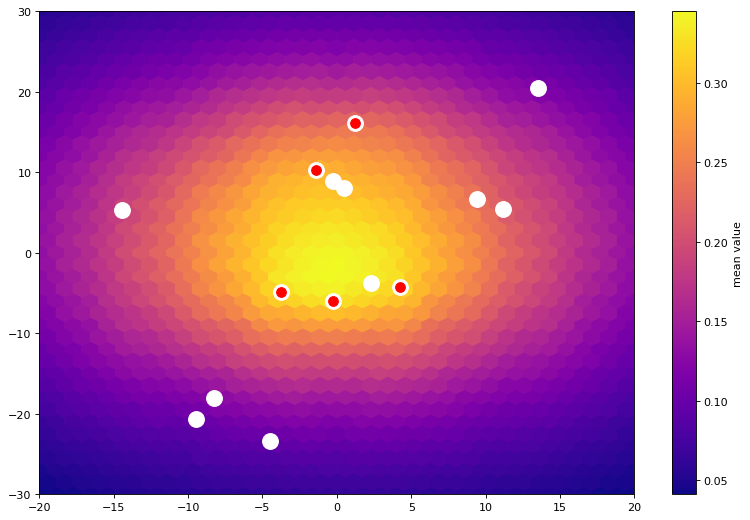

4


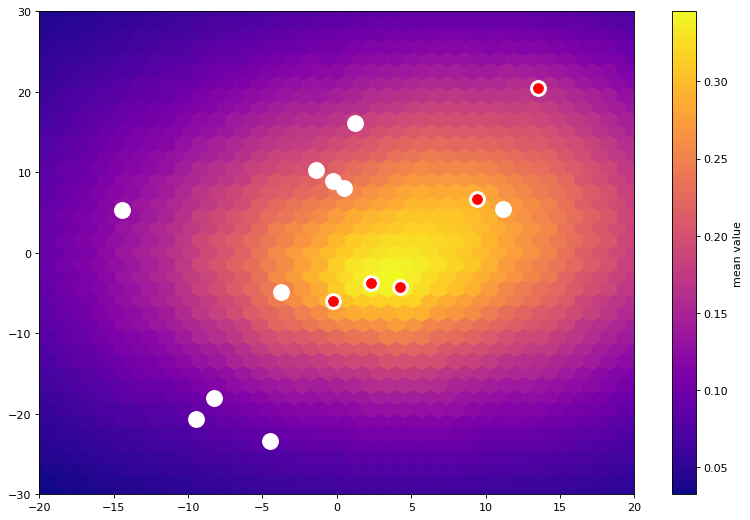

5


6


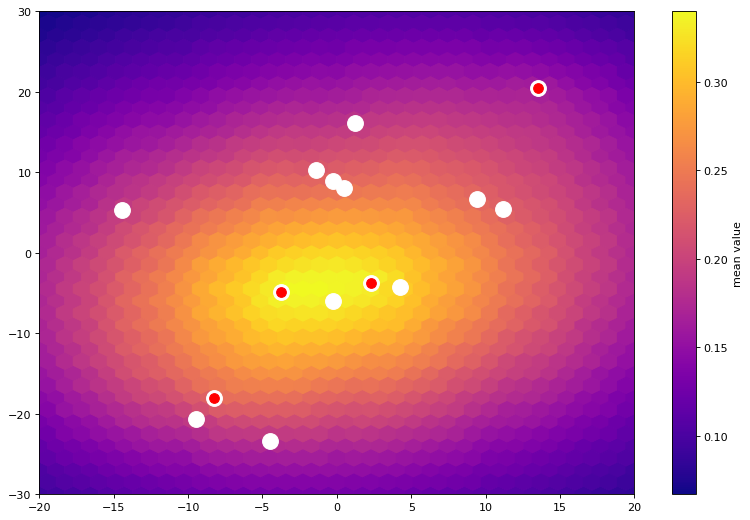

7


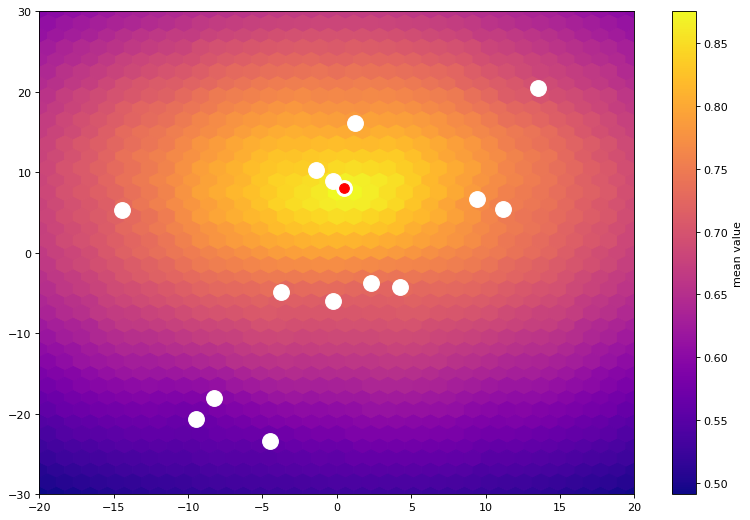

8


9


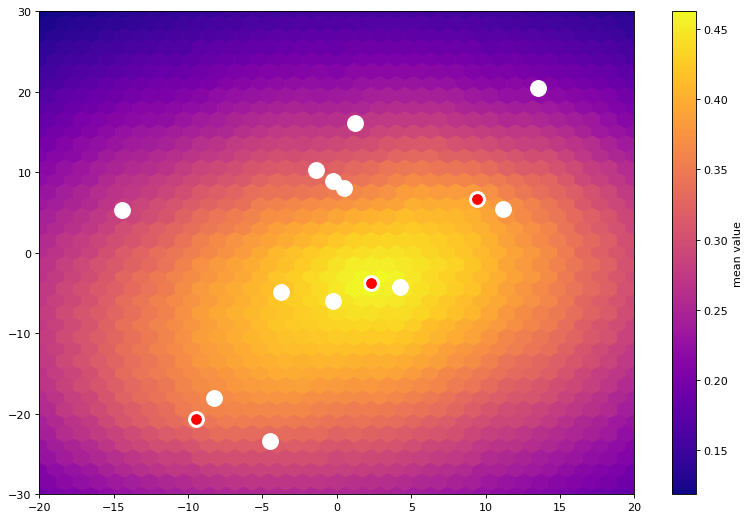

CPU times: user 6.9 s, sys: 170 ms, total: 7.07 s
Wall time: 9.3 s


In [15]:
%%time
#Old time CPU times: user 2min 4s, sys: 3.27 s, total: 2min 7s
#Wall time: 2min 13s
i=0
for familia in familias:
    i+=1
    if i<10:
        print(i)
        sitios=familia["sitios"]
        if len(sitios)>0:
            j=0
            fams={}
            for k in information:
                if k in sitios: fams[k]=1
                else: fams[k]=0
            Z=get_veros(lams1, lams2, 0.3, lams2[18], nvisit, visit, xr, yr, fams)
            figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')


            gridsize=35
            plt.subplot(111)




            plt.hexbin(xr, yr, C=Z, gridsize=gridsize, cmap=CM.plasma, bins=None)
            plt.axis(pls)
            cb = plt.colorbar()
            cb.set_label('mean value')

            for familia in fams:
                if fams[familia]==1: 
                    plt.scatter(information[familia]["utm_xy"][0], information[familia]["utm_xy"][1], c="white", s=200)
                    plt.scatter(information[familia]["utm_xy"][0], information[familia]["utm_xy"][1], c="red", s=75)
                    
                if fams[familia]==0: 
                    plt.scatter(information[familia]["utm_xy"][0], information[familia]["utm_xy"][1], c="white", s=200)
                    plt.scatter(information[familia]["utm_xy"][0], information[familia]["utm_xy"][1], c="white", s=75)

            plt.show()   

## Best parameters by family

In [16]:
for key in familias2:
    print("key "+str(key))
    indx=0
    for familia in familias2[key]:
        if "Max_ver" not in familia:
            print(indx, end="         \r")
            if key-0.1 in familias2 and len(familias2[key-0.1][indx]["sitios_set"])==len(familia["sitios_set"]):
                familia["Max_ver"]=familias2[key-0.1][indx]["Max_ver"]
                familia["Mejor_lam1"]=familias2[key-0.1][indx]["Mejor_lam1"]
                familia["Mejor_lam2"]=familias2[key-0.1][indx]["Mejor_lam2"]
            else:
                sitios=familia["sitios_set"]
                Z=0
                j=0
                fams={}
                for k in information:
                    if k in sitios: fams[k]=1
                    else: fams[k]=0
                lam1_gan=lams1[0]
                lam2_gan=lams2[0]
                for lam1 in lams1:
                    for lam2 in lams2:
                        R=np.max(get_veros(lams1, lams2, lam1, lam2, nvisit, visit, xr, yr, fams))
                        if R>Z:
                            Z=R
                            lam1_gan=lam1
                            lam2_gan=lam2
                familia["Max_ver"]=Z
                familia["Mejor_lam1"]=lam1_gan
                familia["Mejor_lam2"]=lam2_gan
        indx+=1


key 0.0
key 0.1     
key 0.2     
key 0.3     
key 0.4     
key 0.5     
key 0.6     
key 0.7     
key 0.8     
key 0.9     


### Relationship between likelihood of family (COLONY by Wang) and likelihood of geographical distribution and best $\Lambda$

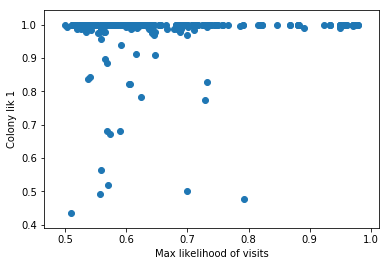

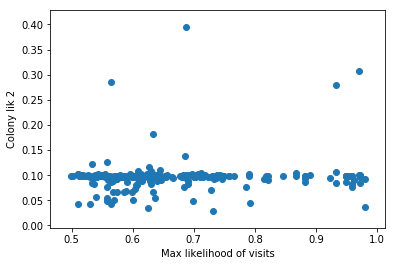

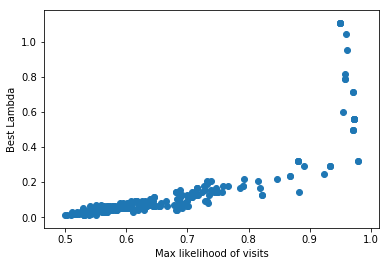

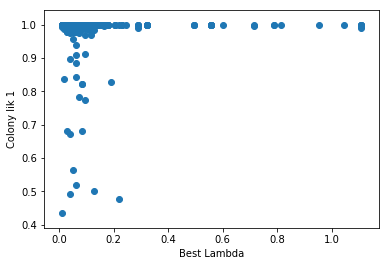

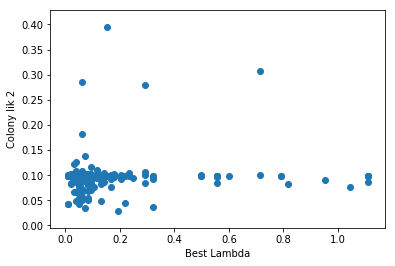

In [17]:
familias=familias2[0.0]

max_vers=[familia["Max_ver"] for familia in familias]
m_lam2=[familia["Mejor_lam2"] for familia in familias]
c1s=[familia["c1"] for familia in familias]
c2s=[familia["c2"] for familia in familias]

plt.scatter(max_vers, c1s)
plt.xlabel("Max likelihood of visits")
plt.ylabel("Colony lik 1")
plt.show()

plt.scatter(max_vers, c2s)
plt.xlabel("Max likelihood of visits")
plt.ylabel("Colony lik 2")
plt.show()

plt.scatter(max_vers, m_lam2)
plt.xlabel("Max likelihood of visits")
plt.ylabel("Best Lambda")
plt.show()

plt.scatter(m_lam2, c1s)
plt.xlabel("Best Lambda")
plt.ylabel("Colony lik 1")
plt.show()

plt.scatter(m_lam2, c2s)
plt.xlabel("Best Lambda")
plt.ylabel("Colony lik 2")
plt.show()

Mejor lambda

In [18]:
aleles=["Al1", "Al2", "Al3", "Al4", "Al5", "Al6", "Al7"]
distribution={}
for alele in aleles:
    tot=list(df_syd2018[alele])
    distribution[alele]={}
    for a in tot:
        if a not in distribution[alele]: distribution[alele][a]=0
        distribution[alele][a]+=1/float(len(tot))
    

In [ ]:
len()

In [19]:
named_df=df_syd2018.set_index("name1")
indx=0
print(len(familias))
for familia in familias:
    print(indx, end="        \r")
    indx=indx+1
    old_prob=[]
    distancias_np=[]
    distancias_genetica3=[]
    distancias_genetica4=1
    distancias_genetica2=[]
    distancias_genetica1=[]
    distancias_fisica=[]
    for integrante in familia["integrantes"]:
        old_prob.append(named_df.loc[integrante]["Old prob"])
        distancias_np.append(information[named_df.loc[integrante]["Site"]]["distance_np"])
    familia["old prob"]=np.mean(old_prob)
    familia["distance np"]=np.mean(distancias_np)
    familia["probas"]={}
    i=0
    for integrante1 in familia["integrantes"]:
        j=0
        i=i+1
        for integrante2 in familia["integrantes"]:
            
            j=j+1
            if j>i:
                distancias_fisica.append(distancia_fisica(named_df.loc[integrante1]["Site"], named_df.loc[integrante2]["Site"], information))
                distancias_genetica1.append(distancia_genetica1(named_df.loc[integrante1], named_df.loc[integrante2], distribution))
                distancias_genetica2.append(distancia_genetica2(named_df.loc[integrante1], named_df.loc[integrante2], distribution))
                distancias_genetica3.append(distancia_genetica3(named_df.loc[integrante1], named_df.loc[integrante2], distribution))
                didi=distancia_genetica4(named_df.loc[integrante1], named_df.loc[integrante2], distribution)
                distancias_genetica4=distancias_genetica4*didi
                familia["probas"][(integrante1, integrante2)]=didi
    integ=len(familia["integrantes"])  
    familia["Distancias fisicas"]=np.mean(distancias_fisica)
    familia["Distancia genética I"]=np.mean(distancias_genetica1)
    familia["Distancia genética II"]=np.mean(distancias_genetica2)
    familia["Distancia genética III"]=np.mean(distancias_genetica3)
    if integ>1: 
        expon=1/(integ*(integ-1)/2)
        familia["Distancia genética IV"]=distancias_genetica4**(expon)
    else:
        familia["Distancia genética IV"]=0
    

269


/Users/Bernardo/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Bernardo/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
for familia in familias:
    print("Familia : "+", ".join(familia["integrantes"]))
    print("Probabilidad: "+str(familia["Distancia genética IV"]))
    for proba in familia["probas"]:
        print("Proba "+proba[0]+"-"+proba[1]+": "+str(round(familia["probas"][proba], 3)))
    print("")
    
    

Familia : 104.2RG, 137.2RG, 50.9RG, 88.2RG, 73.13RG, 86.2RG
Probabilidad: 0.10840872789305898
Proba 104.2RG-137.2RG: 0.009
Proba 104.2RG-50.9RG: 0.217
Proba 104.2RG-88.2RG: 0.125
Proba 104.2RG-73.13RG: 0.196
Proba 104.2RG-86.2RG: 0.196
Proba 137.2RG-50.9RG: 0.001
Proba 137.2RG-88.2RG: 0.594
Proba 137.2RG-73.13RG: 0.555
Proba 137.2RG-86.2RG: 0.555
Proba 50.9RG-88.2RG: 0.025
Proba 50.9RG-73.13RG: 0.041
Proba 50.9RG-86.2RG: 0.041
Proba 88.2RG-73.13RG: 0.234
Proba 88.2RG-86.2RG: 0.234
Proba 73.13RG-86.2RG: 0.975

Familia : 68.2RG, 89.6RG, 74.13RG, 56.6
Probabilidad: 0.01672260270278714
Proba 68.2RG-89.6RG: 0.015
Proba 68.2RG-74.13RG: 0.019
Proba 68.2RG-56.6: 0.001
Proba 89.6RG-74.13RG: 0.02
Proba 89.6RG-56.6: 0.114
Proba 74.13RG-56.6: 0.023

Familia : 47.8RG, 30.17RG, 14.1RG, 91.13RG, 15.12RG, 117.13
Probabilidad: 0.05406604166607759
Proba 47.8RG-30.17RG: 0.55
Proba 47.8RG-14.1RG: 0.01
Proba 47.8RG-91.13RG: 0.009
Proba 47.8RG-15.12RG: 0.083
Proba 47.8RG-117.13: 0.003
Proba 30.17RG-14.1RG: 

Proba 138.14RG-53.12RG: 0.517
Proba 186.11RG-53.12RG: 0.349

Familia : 69.8RG, 71.17RG, 38.9, 10.8
Probabilidad: 0.013973912631112867
Proba 69.8RG-71.17RG: 0.078
Proba 69.8RG-38.9: 0.003
Proba 69.8RG-10.8: 0.019
Proba 71.17RG-38.9: 0.008
Proba 71.17RG-10.8: 0.045
Proba 38.9-10.8: 0.004

Familia : 100.12RG, 152.3, 35.8, 135.2, 26.13
Probabilidad: 0.03378123644661711
Proba 100.12RG-152.3: 0.012
Proba 100.12RG-35.8: 0.024
Proba 100.12RG-135.2: 0.075
Proba 100.12RG-26.13: 0.214
Proba 152.3-35.8: 0.008
Proba 152.3-135.2: 0.023
Proba 152.3-26.13: 0.073
Proba 35.8-135.2: 0.013
Proba 35.8-26.13: 0.009
Proba 135.2-26.13: 0.268

Familia : 93.19RG, 55.13RG, 137.13RG, 2.13RG, 102.14RG, 91.19RG, 131.19RG, 147.18
Probabilidad: 0.2868563412904895
Proba 93.19RG-55.13RG: 0.517
Proba 93.19RG-137.13RG: 0.713
Proba 93.19RG-2.13RG: 0.866
Proba 93.19RG-102.14RG: 0.722
Proba 93.19RG-91.19RG: 0.498
Proba 93.19RG-131.19RG: 0.697
Proba 93.19RG-147.18: 0.008
Proba 55.13RG-137.13RG: 0.864
Proba 55.13RG-2.13RG: 0.

Proba 173.11-46.18: 0.084
Proba 47.18-97.18: 0.015
Proba 47.18-46.8: 0.017
Proba 47.18-46.18: 0.03
Proba 97.18-46.8: 0.12
Proba 97.18-46.18: 0.147
Proba 46.8-46.18: 0.171

Familia : 93.14RG, 137.11RG, 62.17RG, 61.18RG, 126.18RG
Probabilidad: 0.02868749420647246
Proba 93.14RG-137.11RG: 0.235
Proba 93.14RG-62.17RG: 0.047
Proba 93.14RG-61.18RG: 0.025
Proba 93.14RG-126.18RG: 0.014
Proba 137.11RG-62.17RG: 0.594
Proba 137.11RG-61.18RG: 0.002
Proba 137.11RG-126.18RG: 0.001
Proba 62.17RG-61.18RG: 0.003
Proba 62.17RG-126.18RG: 0.022
Proba 61.18RG-126.18RG: 0.945

Familia : 80.5RG, 120.2, 147.11, 5.18
Probabilidad: 0.02063925729730837
Proba 80.5RG-120.2: 0.006
Proba 80.5RG-147.11: 0.055
Proba 80.5RG-5.18: 0.174
Proba 120.2-147.11: 0.025
Proba 120.2-5.18: 0.015
Proba 147.11-5.18: 0.004

Familia : 79.9RG, 32.1, 125.2, 101.5, 34.9
Probabilidad: 0.034189973763430685
Proba 79.9RG-32.1: 0.007
Proba 79.9RG-125.2: 0.022
Proba 79.9RG-101.5: 0.027
Proba 79.9RG-34.9: 0.297
Proba 32.1-125.2: 0.104
Proba 32.

Proba 158.1-95.19: 0.004
Proba 158.1-110.19: 0.004
Proba 158.1-114.19: 0.004
Proba 158.1-152.19: 0.004
Proba 158.1-177.19: 0.004
Proba 158.1-74.2: 0.004
Proba 158.1-109.2: 0.004
Proba 19.6-26.6: 0.004
Proba 19.6-32.6: 0.004
Proba 19.6-39.6: 0.004
Proba 19.6-55.6: 0.004
Proba 19.6-76.6: 0.004
Proba 19.6-91.6: 0.004
Proba 19.6-125.6: 0.004
Proba 19.6-1.11: 0.004
Proba 19.6-15.11: 0.004
Proba 19.6-31.11: 0.004
Proba 19.6-65.11: 0.004
Proba 19.6-72.11: 0.004
Proba 19.6-136.11: 0.004
Proba 19.6-181.11: 0.004
Proba 19.6-1.5: 0.004
Proba 19.6-15.5: 0.004
Proba 19.6-26.5: 0.004
Proba 19.6-45.5: 0.004
Proba 19.6-61.5: 0.004
Proba 19.6-74.5: 0.004
Proba 19.6-73.18: 0.004
Proba 19.6-70.14: 0.004
Proba 19.6-48.19: 0.004
Proba 19.6-60.19: 0.004
Proba 19.6-62.19: 0.004
Proba 19.6-82.19: 0.004
Proba 19.6-92.19: 0.004
Proba 19.6-95.19: 0.004
Proba 19.6-110.19: 0.004
Proba 19.6-114.19: 0.004
Proba 19.6-152.19: 0.004
Proba 19.6-177.19: 0.004
Proba 19.6-74.2: 0.004
Proba 19.6-109.2: 0.004
Proba 26.6-32.6

Proba 19.11-143.19: 0.014
Proba 19.11-125.13: 0.014
Proba 73.19-143.19: 0.014
Proba 73.19-125.13: 0.014
Proba 143.19-125.13: 0.014

Familia : 68.8, 7.7, 56.7, 67.7, 69.7, 25.1, 124.3, 142.3, 144.3, 11.6, 64.6, 148.6, 151.6, 64.11, 32.19, 170.19, 93.2
Probabilidad: 0.00925751836193994
Proba 68.8-7.7: 0.009
Proba 68.8-56.7: 0.009
Proba 68.8-67.7: 0.009
Proba 68.8-69.7: 0.009
Proba 68.8-25.1: 0.009
Proba 68.8-124.3: 0.009
Proba 68.8-142.3: 0.009
Proba 68.8-144.3: 0.009
Proba 68.8-11.6: 0.009
Proba 68.8-64.6: 0.009
Proba 68.8-148.6: 0.009
Proba 68.8-151.6: 0.009
Proba 68.8-64.11: 0.009
Proba 68.8-32.19: 0.009
Proba 68.8-170.19: 0.009
Proba 68.8-93.2: 0.009
Proba 7.7-56.7: 0.009
Proba 7.7-67.7: 0.009
Proba 7.7-69.7: 0.009
Proba 7.7-25.1: 0.009
Proba 7.7-124.3: 0.009
Proba 7.7-142.3: 0.009
Proba 7.7-144.3: 0.009
Proba 7.7-11.6: 0.009
Proba 7.7-64.6: 0.009
Proba 7.7-148.6: 0.009
Proba 7.7-151.6: 0.009
Proba 7.7-64.11: 0.009
Proba 7.7-32.19: 0.009
Proba 7.7-170.19: 0.009
Proba 7.7-93.2: 0.009


Proba 78.19-8.3: 0.021
Proba 78.19-126.19: 0.021
Proba 78.19-76.3: 0.046
Proba 78.19-111.2: 0.014
Proba 8.3-126.19: 0.083
Proba 8.3-76.3: 0.013
Proba 8.3-111.2: 0.059
Proba 126.19-76.3: 0.013
Proba 126.19-111.2: 0.059
Proba 76.3-111.2: 0.036

Familia : 75.1, 97.1, 137.3, 157.11, 24.5, 2.8, 119.3, 104.5
Probabilidad: 0.02304928825306289
Proba 75.1-97.1: 0.021
Proba 75.1-137.3: 0.021
Proba 75.1-157.11: 0.021
Proba 75.1-24.5: 0.021
Proba 75.1-2.8: 0.021
Proba 75.1-119.3: 0.021
Proba 75.1-104.5: 0.021
Proba 97.1-137.3: 0.021
Proba 97.1-157.11: 0.021
Proba 97.1-24.5: 0.021
Proba 97.1-2.8: 0.021
Proba 97.1-119.3: 0.021
Proba 97.1-104.5: 0.021
Proba 137.3-157.11: 0.021
Proba 137.3-24.5: 0.021
Proba 137.3-2.8: 0.021
Proba 137.3-119.3: 0.021
Proba 137.3-104.5: 0.021
Proba 157.11-24.5: 0.021
Proba 157.11-2.8: 0.021
Proba 157.11-119.3: 0.021
Proba 157.11-104.5: 0.021
Proba 24.5-2.8: 0.021
Proba 24.5-119.3: 0.021
Proba 24.5-104.5: 0.021
Proba 2.8-119.3: 0.048
Proba 2.8-104.5: 0.048
Proba 119.3-104


Familia : 6.7, 8.7, 47.3, 100.5, 4.7, 30.7, 48.7, 62.7, 12.7
Probabilidad: 0.04588683129429515
Proba 6.7-8.7: 0.038
Proba 6.7-47.3: 0.038
Proba 6.7-100.5: 0.038
Proba 6.7-4.7: 0.035
Proba 6.7-30.7: 0.035
Proba 6.7-48.7: 0.035
Proba 6.7-62.7: 0.045
Proba 6.7-12.7: 0.041
Proba 8.7-47.3: 0.038
Proba 8.7-100.5: 0.038
Proba 8.7-4.7: 0.035
Proba 8.7-30.7: 0.035
Proba 8.7-48.7: 0.035
Proba 8.7-62.7: 0.045
Proba 8.7-12.7: 0.041
Proba 47.3-100.5: 0.038
Proba 47.3-4.7: 0.035
Proba 47.3-30.7: 0.035
Proba 47.3-48.7: 0.035
Proba 47.3-62.7: 0.045
Proba 47.3-12.7: 0.041
Proba 100.5-4.7: 0.035
Proba 100.5-30.7: 0.035
Proba 100.5-48.7: 0.035
Proba 100.5-62.7: 0.045
Proba 100.5-12.7: 0.041
Proba 4.7-30.7: 0.1
Proba 4.7-48.7: 0.1
Proba 4.7-62.7: 0.026
Proba 4.7-12.7: 0.115
Proba 30.7-48.7: 0.1
Proba 30.7-62.7: 0.026
Proba 30.7-12.7: 0.115
Proba 48.7-62.7: 0.026
Proba 48.7-12.7: 0.115
Proba 62.7-12.7: 0.175

Familia : 113.18, 19.19, 21.19, 37.19, 45.19, 49.19, 64.19, 72.19, 83.19, 87.19, 100.19, 103.19, 

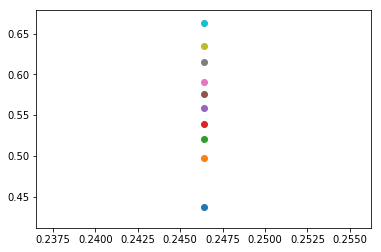

In [21]:
tots=[]
for d in familias2:
    points=[]
    lam2=lams2[20]
    ii=0
    totprob=1
    for familia in familias2[d]:
        print(str(d)+" - "+str(lam2)+" - "+str(ii)+"/"+str(len(familias2[d])), end="        \r")
        if len(familia["integrantes"])>1:
            sitios=familia["sitios"]
            Z=0
            j=0
            fams={}
            for k in information:
                if k in sitios: fams[k]=1
                else: fams[k]=0
            #print(list(set(sitios)))
            for lam1 in lams1:
                R=np.max(get_veros(lams1, lams2, lam1, lam2, nvisit, visit, xr, yr, fams))
                if R>Z:
                    Z=R
            totprob*=Z
            ii+=1
    plt.scatter(lam2, totprob**(1/ii))

In [22]:
tots_d={}
for d in familias2:
    tots_d[d]=0
    for familia in familias2[d]:
        print(str(d)+" - "+str(lam2)+" - "+str(ii)+"/"+str(len(familias2[d])), end="        \r")
        if len(familia["integrantes"])>1:
            tots_d[d]+=1
    
                

0.8 - 0.24639722235796316 - 163/269

In [23]:
for d in totpoints:
    plt.plot([1/lam for lam in lams2], [i**(1/tots_d[d]) for i in totpoints[d]], color=(0,0,d))
plt.xlim([0,10.0])
plt.ylim([0.4, 0.7])

NameError: name 'totpoints' is not defined

In [24]:
totals={}
for d in familias2:
    points=[]
    for lam2 in lams2:
        ii=0
        totss=0
        totprob=1
        for familia in familias2[d]:
            print(str(d)+" - "+str(lam2)+" - "+str(ii)+"/"+str(len(familias2[d])), end="        \r")
            if len(familia["integrantes"])>1:
                sitios=familia["sitios"]
                Z=0
                j=0
                fams={}
                for k in information:
                    if k in sitios: fams[k]=1
                    else: fams[k]=0
                for lam1 in lams1:
                    R=np.max(get_veros(lams1, lams2, lam1, lam2, nvisit, visit, xr, yr, fams))
                    if R>Z:
                        Z=R
            ii+=1
            totprob=totprob*Z
        points.append(totprob)
    plt.plot(lams2, points)
    totpoints[d]=points
                
        

KeyboardInterrupt: 

In [ ]:
get_veros(lams1, lams2, lam1, lam2, nvisit, visit, xr, yr, fams)

In [ ]:
1

In [25]:
verosimilitud=[]
verosimilitudes_distancia={}
verosimilitudes_distancia_doble={}
verosimilitudes_prob={}
verosimilitudes_distancia_np={}
distancias=[i/10.0 for i in range(10)]
distancias_doble=[i/10.0 for i in range(10)]
distancias_np=[i*2 for i in range(10)]
old_prob_vals=[i/10.0 for i in range(10)]
distancias_g4=[i/10.0 for i in range(10)]
verosimilitudes_distancia_g4={}


for d in distancias_doble:
        verosimilitudes_distancia_doble[d]=[]
for d in distancias:
        verosimilitudes_distancia[d]=[]
for d in distancias_np:
        verosimilitudes_distancia_np[d]=[]
for d in old_prob_vals:
        verosimilitudes_prob[d]=[]
for d in distancias_g4:
    verosimilitudes_distancia_g4[d]=[]
    
for lam2 in lams2:
    ver=1
    ver_d={}
    ver_d_doble={}
    ver_np={}
    ver_op={}
    ver_d_g4={}
    tut_d_g4={}
    
    tut_d={}
    tut_d_doble={}
    tut_np={}
    tut_op={}
    for d in distancias:
        ver_d[d]=1
        tut_d[d]=0
    for d in distancias_doble:
        ver_d_doble[d]=1
        tut_d_doble[d]=0
    for d in distancias_np:
        ver_np[d]=1
        tut_np[d]=0
    for d in old_prob_vals:
        ver_op[d]=1
        tut_op[d]=0
    for d in distancias_g4:
        ver_d_g4[d]=1
        tut_d_g4[d]=0
        
    tut=0
    for familia in familias:
        print(str(lam2)+" - "+str(tut), end="      \r")
        tut=tut+1
        sitios=familia["sitios"]
        Z=0
        j=0
        fams={}
        for k in information:
            if k in sitios: fams[k]=1
            else: fams[k]=0
        for lam1 in lams1:
            R=np.max(get_veros(lams1, lams2, lam1, lam2, nvisit, visit, xr, yr, fams))
            if R>Z:
                Z=R
        if Z==0: raise Exception("Algo está mal")
        ver=ver*Z
        
        for d in distancias:
            if familia["Distancia genética III"]>d: 
                ver_d[d]=ver_d[d]*Z
                tut_d[d]+=1
        for d in distancias_doble:
            if familia["Distancia genética III"]>d and familia["old prob"]>d: 
                ver_d_doble[d]=ver_d_doble[d]*Z
                tut_d_doble[d]+=1
                
        for d in distancias_np:
            if familia["distance np"]>d: 
                ver_np[d]=ver_np[d]*Z
                tut_np[d]+=1
                
        for d in old_prob_vals:
            if familia["old prob"]>d: 
                ver_op[d]=ver_op[d]*Z
                tut_op[d]+=1
                
        for d in distancias_g4:
            if familia["Distancia genética IV"]>d: 
                ver_d_g4[d]=ver_d_g4[d]*Z
                tut_d_g4[d]+=1
                
    ver=ver**(1/tut)
    for d in distancias:
        ver_d[d]=ver_d[d]**(1/tut_d[d])
        verosimilitudes_distancia[d].append(ver_d[d])
        
    for d in distancias_doble:
        ver_d_doble[d]=ver_d_doble[d]**(1/tut_d_doble[d])
        verosimilitudes_distancia_doble[d].append(ver_d_doble[d])

    for d in distancias_np:
        ver_np[d]=ver_np[d]**(1/tut_np[d])
        verosimilitudes_distancia_np[d].append(ver_np[d])

    for d in old_prob_vals:
        ver_op[d]=ver_op[d]**(1/tut_op[d])
        verosimilitudes_prob[d].append(ver_op[d])
        
    for d in distancias_g4:
        ver_d_g4[d]=ver_d_g4[d]**(1/tut_d_g4[d])
        verosimilitudes_distancia_g4[d].append(ver_d_g4[d])
        
    verosimilitud.append(ver)
        
    

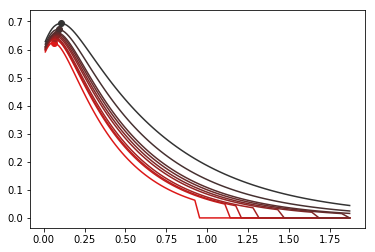

In [26]:
c1="#333333"
c2="#dd1818"

for d in old_prob_vals:
    color=gradient(c1, c2, d/0.9)
    plt.plot(lams2, verosimilitudes_prob[d], c=color)
    maxi=np.max(verosimilitudes_prob[d])
    plt.scatter(lams2[verosimilitudes_prob[d].index(maxi)], maxi, c=[color])

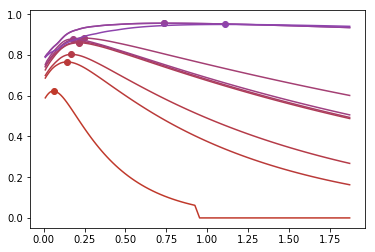

In [27]:
c1="#8e44ad"
c2="#c0392b"
for d in distancias_g4:
    color=gradient(c1, c2, d/0.9)
    plt.plot(lams2, verosimilitudes_distancia_g4[d], c=color)
    maxi=np.max(verosimilitudes_distancia_g4[d])
    plt.scatter(lams2[verosimilitudes_distancia_g4[d].index(maxi)], maxi, c=[color])
    

In [28]:
tut_d_g4

{0.0: 263,
 0.1: 42,
 0.2: 18,
 0.3: 9,
 0.4: 7,
 0.5: 5,
 0.6: 3,
 0.7: 2,
 0.8: 2,
 0.9: 1}

In [11]:
aleles=["Al1", "Al2", "Al3", "Al4", "Al5", "Al6", "Al7"]
distribution={}
for alele in aleles:
    tot=list(df_syd2018[alele])
    distribution[alele]={}
    for a in tot:
        if a not in distribution[alele]: distribution[alele][a]=0
        distribution[alele][a]+=1/float(len(tot))
    

In [30]:
named_df=df_syd2018.set_index("name1")
indx=0
print(len(familias))
for familia in familias:
    print(indx, end="        \r")
    indx=indx+1
    old_prob=[]
    distancias_np=[]
    distancias_genetica3=[]
    distancias_genetica4=1
    distancias_genetica2=[]
    distancias_genetica1=[]
    distancias_fisica=[]
    for integrante in familia["integrantes"]:
        old_prob.append(named_df.loc[integrante]["Old prob"])
        distancias_np.append(information[named_df.loc[integrante]["Site"]]["distance_np"])
    familia["old prob"]=np.mean(old_prob)
    familia["distance np"]=np.mean(distancias_np)
    i=0
    for integrante1 in familia["integrantes"]:
        j=0
        i=i+1
        for integrante2 in familia["integrantes"]:
            
            j=j+1
            if j>i:
                distancias_fisica.append(distancia_fisica(named_df.loc[integrante1]["Site"], named_df.loc[integrante2]["Site"], information))
                distancias_genetica1.append(distancia_genetica1(named_df.loc[integrante1], named_df.loc[integrante2], distribution))
                distancias_genetica2.append(distancia_genetica2(named_df.loc[integrante1], named_df.loc[integrante2], distribution))
                distancias_genetica3.append(distancia_genetica3(named_df.loc[integrante1], named_df.loc[integrante2], distribution))
                distancias_genetica4=distancias_genetica4*distancia_genetica4(named_df.loc[integrante1], named_df.loc[integrante2], distribution)
    integ=len(familia["integrantes"])  
    familia["Distancias fisicas"]=np.mean(distancias_fisica)
    familia["Distancia genética I"]=np.mean(distancias_genetica1)
    familia["Distancia genética II"]=np.mean(distancias_genetica2)
    familia["Distancia genética III"]=np.mean(distancias_genetica3)
    if integ>1: 
        expon=1/(integ*(integ-1)/2)
        familia["Distancia genética IV"]=distancias_genetica4**(expon)
    else:
        familia["Distancia genética IV"]=0
    

269


In [31]:
verosimilitud=[]
verosimilitudes_distancia={}
verosimilitudes_distancia_doble={}
verosimilitudes_prob={}
verosimilitudes_distancia_np={}
distancias=[i/10.0 for i in range(10)]
distancias_doble=[i/10.0 for i in range(10)]
distancias_np=[i*2 for i in range(10)]
old_prob_vals=[i/10.0 for i in range(10)]
distancias_g4=[i/10.0 for i in range(10)]
verosimilitudes_distancia_g4={}


for d in distancias_doble:
        verosimilitudes_distancia_doble[d]=[]
for d in distancias:
        verosimilitudes_distancia[d]=[]
for d in distancias_np:
        verosimilitudes_distancia_np[d]=[]
for d in old_prob_vals:
        verosimilitudes_prob[d]=[]
for d in distancias_g4:
    verosimilitudes_distancia_g4[d]=[]
    
for lam2 in lams2:
    ver=1
    ver_d={}
    ver_d_doble={}
    ver_np={}
    ver_op={}
    ver_d_g4={}
    tut_d_g4={}
    
    tut_d={}
    tut_d_doble={}
    tut_np={}
    tut_op={}
    for d in distancias:
        ver_d[d]=1
        tut_d[d]=0
    for d in distancias_doble:
        ver_d_doble[d]=1
        tut_d_doble[d]=0
    for d in distancias_np:
        ver_np[d]=1
        tut_np[d]=0
    for d in old_prob_vals:
        ver_op[d]=1
        tut_op[d]=0
    for d in distancias_g4:
        ver_d_g4[d]=1
        tut_d_g4[d]=0
        
    tut=0
    for familia in familias:
        print(str(lam2)+" - "+str(tut), end="      \r")
        tut=tut+1
        sitios=familia["sitios"]
        Z=0
        j=0
        fams={}
        for k in information:
            if k in sitios: fams[k]=1
            else: fams[k]=0
        for lam1 in lams1:
            R=np.max(get_veros(lams1, lams2, lam1, lam2, nvisit, visit, xr, yr, fams))
            if R>Z:
                Z=R
        if Z==0: raise Exception("Algo está mal")
        ver=ver*Z
        
        for d in distancias:
            if familia["Distancia genética III"]>d: 
                ver_d[d]=ver_d[d]*Z
                tut_d[d]+=1
                
        for d in distancias_doble:
            if familia["Distancia genética III"]>d and familia["old prob"]>d: 
                ver_d_doble[d]=ver_d_doble[d]*Z
                tut_d_doble[d]+=1
                
        for d in distancias_np:
            if familia["distance np"]>d: 
                ver_np[d]=ver_np[d]*Z
                tut_np[d]+=1
                
        for d in old_prob_vals:
            if familia["old prob"]>d: 
                ver_op[d]=ver_op[d]*Z
                tut_op[d]+=1
                
        for d in distancias_g4:
            if familia["Distancia genética IV"]>d: 
                ver_d_g4[d]=ver_d_g4[d]*Z
                tut_d_g4[d]+=1
                
    ver=ver**(1/tut)
    for d in distancias:
        ver_d[d]=ver_d[d]**(1/tut_d[d])
        verosimilitudes_distancia[d].append(ver_d[d])
        
    for d in distancias_doble:
        ver_d_doble[d]=ver_d_doble[d]**(1/tut_d_doble[d])
        verosimilitudes_distancia_doble[d].append(ver_d_doble[d])

    for d in distancias_np:
        ver_np[d]=ver_np[d]**(1/tut_np[d])
        verosimilitudes_distancia_np[d].append(ver_np[d])

    for d in old_prob_vals:
        ver_op[d]=ver_op[d]**(1/tut_op[d])
        verosimilitudes_prob[d].append(ver_op[d])
        
    for d in distancias_g4:
        ver_d_g4[d]=ver_d_g4[d]**(1/tut_d_g4[d])
        verosimilitudes_distancia_g4[d].append(ver_d_g4[d])
        
    verosimilitud.append(ver)
        
    

(0, 10)

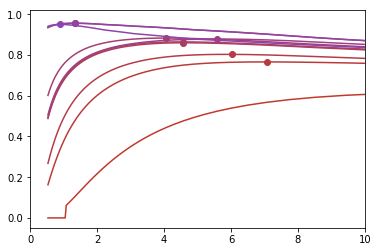

In [32]:
c1="#8e44ad"
c2="#c0392b"
for d in distancias_g4:
    color=gradient(c1, c2, d/0.9)
    plt.plot([1/lam for lam in lams2], verosimilitudes_distancia_g4[d], c=color)
    maxi=np.max(verosimilitudes_distancia_g4[d])
    plt.scatter(1/lams2[verosimilitudes_distancia_g4[d].index(maxi)], maxi, c=[color])

plt.xlim(0,10)

In [33]:
import pickle 
ff=open("fig1.pkl", "rb")
fig_2=pickle.load( ff)
ff.close()

In [34]:
flag

NameError: name 'flag' is not defined

In [35]:
dfPC2018=df[df.Cluster=='PC2018'].sort_values(aleles)

In [36]:
df.iloc[0]

Collection site         UNISYD
name0              104.2RGSYD8
name1                  104.2RG
Al1                        157
Al2                        143
Al3                        175
Al4                        154
Al5                        206
Al6                        233
Al7                        137
Old prob              0.950167
Cluster                 PC2018
Site                Camperdown
Name: 0, dtype: object

In [2]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
dfPC2018=df[df.Cluster=='PC2018'].sort_values(aleles)

f=plt.figure(figsize=(16,16))
ax=plt.subplot(int(str("211")))    

k=1

op=0.95
sitios=list(set(dfPC2018.Site))
j=0
gemels=[]
while j<len(dfPC2018):
        if dfPC2018.iloc[j]["Old prob"]>=op:
            i=j+1
            flag=len(aleles)
            while flag==len(aleles) and i<len(dfPC2018):
                flag=0
                while flag<len(aleles) and dfPC2018.iloc[j][aleles[flag]]==dfPC2018.iloc[i][aleles[flag]] : flag+=1
                if flag==len(aleles):
                    gemels.append(([dfPC2018.iloc[j]["Site"], 
                                                  dfPC2018.iloc[i]["Site"]]))
                i+=1
        j+=1


dict_nums={}
for i in range(50):
        dict_nums[i]=0

dict_visitas={}
for i in range(50):
        dict_visitas[i]=0

a=0
while a<len(sitios):
        b=a+1
        while b<len(sitios):
            d=euclidean_dist(information[sitios[a]]["utm_xy"], 
                             information[sitios[b]]["utm_xy"])
            dict_nums[int(round(d))]+=1
            b+=1
        a+=1

for g in gemels:
        d=euclidean_dist(information[g[0]]["utm_xy"], 
                             information[g[1]]["utm_xy"])
        dict_visitas[int(round(d))]+=1

k+=1
ys_95=[dict_visitas[d] for d in range(0,30)]
plt.bar([d for d in range(0, 30)], [dict_visitas[d] for d in range(0,30)], width=0.9, label=">=0.95")


j=0
gemels=[]
while j<len(dfPC2018):
        if dfPC2018.iloc[j]["Old prob"]>=0.85 and dfPC2018.iloc[j]["Old prob"]<0.95:
            i=j+1
            flag=len(aleles)
            while flag==len(aleles) and i<len(dfPC2018):
                flag=0
                while flag<len(aleles) and dfPC2018.iloc[j][aleles[flag]]==dfPC2018.iloc[i][aleles[flag]] : flag+=1
                if flag==len(aleles):
                    gemels.append(([dfPC2018.iloc[j]["Site"], 
                                                  dfPC2018.iloc[i]["Site"]]))
                i+=1
        j+=1


dict_nums={}
for i in range(50):
        dict_nums[i]=0

dict_visitas={}
for i in range(50):
        dict_visitas[i]=0

a=0
while a<len(sitios):
        b=a
        while b<len(sitios):
            d=euclidean_dist(information[sitios[a]]["utm_xy"], 
                             information[sitios[b]]["utm_xy"])
            dict_nums[int(round(d))]+=1
            b+=1
        a+=1

for g in gemels:
        d=euclidean_dist(information[g[0]]["utm_xy"], 
                             information[g[1]]["utm_xy"])
        dict_visitas[int(round(d))]+=1

k+=1
plt.bar([d for d in range(0, 30)], [dict_visitas[d] for d in range(0,30)], bottom=ys_95, width=0.9, label="[0.85, 0.95)")





plt.title("Number of twins with more than "+str(op)+" probability of sibship\n by distance between sites")

ax.set_yscale('symlog')

ax.legend()

  
plt.bar([d for d in range(0, 30)], [dict_nums[d] for d in range(0,30)], width=0.9, color="orange")
plt.title("Number of pair of sites at each distance")
plt.subplot(int(str("211")))  
plt.xtitle("kms separating pair of bees")
plt.xtitle("Frequency")

plt.subplot(int(str("212")))  
plt.xtitle("kms separating pair of sites")
plt.xtitle("Frequency")

plt.show()
f.savefig("twins.pdf")


NameError: name 'df' is not defined

In [13]:
set(df.Cluster)

{'PC2017', 'PC2018', 'QL2017'}

KeyError: 'Marrickville sp'

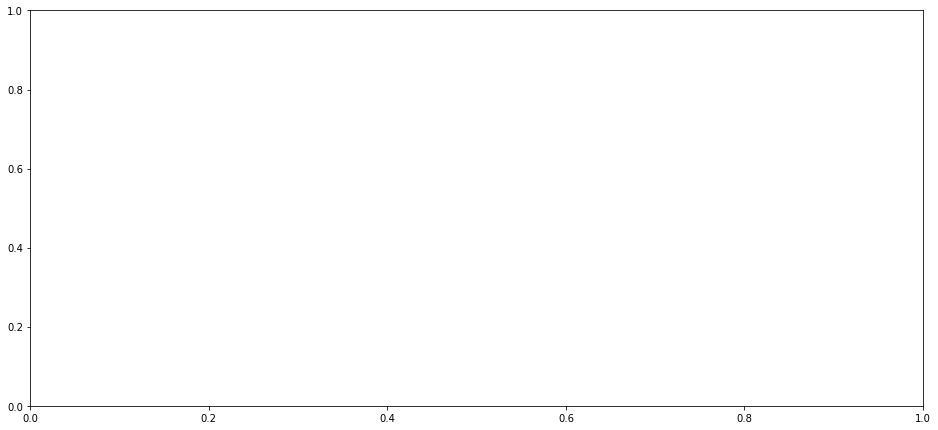

In [14]:
dfPC2018=df[df.Cluster=='PC2017'].sort_values(aleles)

f=plt.figure(figsize=(16,16))
ax=plt.subplot(int(str("211")))    

k=1

op=0.95
sitios=list(set(dfPC2018.Site))
j=0
gemels=[]
while j<len(dfPC2018):
        if dfPC2018.iloc[j]["Old prob"]>=op:
            i=j+1
            flag=len(aleles)
            while flag==len(aleles) and i<len(dfPC2018):
                flag=0
                while flag<len(aleles) and dfPC2018.iloc[j][aleles[flag]]==dfPC2018.iloc[i][aleles[flag]] : flag+=1
                if flag==len(aleles):
                    gemels.append(([dfPC2018.iloc[j]["Site"], 
                                                  dfPC2018.iloc[i]["Site"]]))
                i+=1
        j+=1


dict_nums={}
for i in range(50):
        dict_nums[i]=0

dict_visitas={}
for i in range(50):
        dict_visitas[i]=0

a=0
while a<len(sitios):
        b=a+1
        while b<len(sitios):
            d=euclidean_dist(information[sitios[a]]["utm_xy"], 
                             information[sitios[b]]["utm_xy"])
            dict_nums[int(round(d))]+=1
            b+=1
        a+=1

for g in gemels:
        d=euclidean_dist(information[g[0]]["utm_xy"], 
                             information[g[1]]["utm_xy"])
        dict_visitas[int(round(d))]+=1

k+=1
ys_95=[dict_visitas[d] for d in range(0,40)]
plt.bar([d for d in range(0, 40)],ys_95, width=0.9, label=">=0.95")


j=0
gemels=[]
while j<len(dfPC2018):
        if dfPC2018.iloc[j]["Old prob"]>=0.85 and dfPC2018.iloc[j]["Old prob"]<0.95:
            i=j+1
            flag=len(aleles)
            while flag==len(aleles) and i<len(dfPC2018):
                flag=0
                while flag<len(aleles) and dfPC2018.iloc[j][aleles[flag]]==dfPC2018.iloc[i][aleles[flag]] : flag+=1
                if flag==len(aleles):
                    gemels.append(([dfPC2018.iloc[j]["Site"], 
                                                  dfPC2018.iloc[i]["Site"]]))
                i+=1
        j+=1


dict_nums={}
for i in range(50):
        dict_nums[i]=0

dict_visitas={}
for i in range(50):
        dict_visitas[i]=0

a=0
while a<len(sitios):
        b=a
        while b<len(sitios):
            d=euclidean_dist(information[sitios[a]]["utm_xy"], 
                             information[sitios[b]]["utm_xy"])
            dict_nums[int(round(d))]+=1
            b+=1
        a+=1

for g in gemels:
        d=euclidean_dist(information[g[0]]["utm_xy"], 
                             information[g[1]]["utm_xy"])
        dict_visitas[int(round(d))]+=1

k+=1
plt.bar([d for d in range(0, 40)], [dict_visitas[d] for d in range(0,40)], bottom=ys_95, width=0.9, label="[0.85, 0.95)")





plt.title("Number of twins with more than "+str(op)+" probability of sibship\n by distance between sites", fontsize=18)
#ax.set_xticks([i*2 for i in range(21)])
ax.set_xticks([i*5 for i in range(9)])

ax.set_ylabel("Frquency (log scale)", fontsize=18)


ax.set_yscale('symlog', fontsize=18)

ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

ax.set_xlabel("Distance between pairs", fontsize=18)

#ax.set_ylim([500])

ax.legend(fontsize=16)

ax=plt.subplot(int(str("212")))    
plt.bar([d for d in range(0, 40)], [dict_nums[d] for d in range(0,40)], width=0.9, color="orange")
plt.title("Number of pair of sites at each distance", fontsize=18)
ax.set_ylabel("Frquency", fontsize=18)
ax.set_xlabel("Distance between sites", fontsize=18)
#ax.set_xticks([i*2 for i in range(21)])
ax.set_xticks([i*5 for i in range(9)])


ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

    
plt.show()
f.savefig("twins_5km.pdf")


In [86]:
def final_plot(df_pares_abejas, dic_curva=None):
    f=figure(facecolor="white", edgecolor="black")
    f.set_facecolor('white')
    ax = f.add_subplot(1, 1, 1) # nrows, ncols, index
    ax.set_facecolor("white")
    ma1=5
    ma2=5
    if dic_curva==None:
        dic_curva={}

        for k in range(0, 101, 10):
            print(k, end="   \r")
            cropped=df_pares_abejas[(df_pares_abejas.Similitud_genetica_4>= (k-ma1)/100.0) & 
                                     (df_pares_abejas.Similitud_genetica_4< (k+ma1)/100.0)]
            leni=len(cropped)
            xs=[]
            ys=[]
            for s in range(0, 50):
                #cropped["d2"]=[i+random.normalvariate(0,1) for i in cropped["Distancia"]]
                l1=len(cropped[(cropped.Distancia < (s))])/leni
                xs.append(l1)
                ys.append(s)
            color=(k)/(100)
            c1="#1c92d2"
            c2="#f2fcfe"
            color=gradient(c1, c2, color)
            plt.plot(ys, xs, c=color, label="p ["+str(np.max([(k-ma1)/100.0, 0.0]))+", "+str(np.min([(k+ma1)/100.0, 1])) +")")
            dic_curva[k]=[ys, xs]
    else:
         for k in range(0, 101, 10):
            color=(k)/(100)
            c1="#1c92d2"
            c2="#f2fcfe"
            color=gradient(c1, c2, color)
            xs=dic_curva[k][1]
            ys=dic_curva[k][0]
            plt.plot(ys, xs, c=color, label="p ["+str(np.max([(k-ma1)/100.0, 0.0]))+", "+str(np.min([(k+ma1)/100.0, 1])) +")")
    plt.ylim([0,1])
    plt.legend()
    ax.set_xlabel("Kms between the sites where each pair now collected")
    ax.set_ylabel("Proportion of pairs")
    f.savefig("final_frequencies.pdf")
    plt.show()
    return dic_curva
            

In [90]:
import time

distancias_fisica=[]
distancias_genetica1=[]
distancias_genetica2=[]
distancias_genetica3=[]
distancias_genetica4=[]
misma_familia_wang=[]
distancias_np=[]
suma_probs=[]
c1s=[]
c2s=[]

start=time.time()
i=0
total=len(df_syd2018)
for fam1 in df_syd2018.iterrows():
    i=i+1
    velocidad=i/(time.time()-start)
    quedan=total-i
    tiempo_restante=round((quedan/velocidad)/60.0)
    print(str(i)+"/"+str(total)+" Remaining time="+str(tiempo_restante)+" minutos", end="        \r")
    j=0
    for fam2 in df_syd2018.iterrows():
        j=j+1
        if j>i:
            distancias_fisica.append(distancia_fisica(fam1[1]["Site"], fam2[1]["Site"], information))
            suma_probs.append(fam1[1]["Old prob"]+fam2[1]["Old prob"])
            distancias_genetica1.append(distancia_genetica1(fam1[1], fam2[1], distribution))
            distancias_genetica2.append(distancia_genetica2(fam1[1], fam2[1], distribution))
            distancias_genetica3.append(distancia_genetica3(fam1[1], fam2[1], distribution))
            distancias_genetica4.append(distancia_genetica4(fam1[1], fam2[1], distribution))
            misma_familia_wang.append(int(fam1[1]["Familia"]==fam2[1]["Familia"]))
            distancias_np.append(information[fam1[1]["Site"]]["distance_np"]+information[fam2[1]["Site"]]["distance_np"])
            if fam1[1]["Familia"]==fam2[1]["Familia"]: 
                c1s.append(fam1[1]["C1_familia"])
                c2s.append(fam1[1]["C2_familia"])
            else:
                c1s.append(np.nan)
                c2s.append(np.nan)

In [92]:
df_pares_abejas=pd.DataFrame({"Distancia":distancias_fisica, "Old prob": suma_probs, 
              "Similitud_genetica_1":distancias_genetica1, 
              "Similitud_genetica_2":distancias_genetica2, 
             "Similitud_genetica_3":distancias_genetica3,
             "Similitud_genetica_4":distancias_genetica4,
             "Misma familia": misma_familia_wang, 
             "Distancia_pn": distancias_np, 
            "c1":c1s, "c2":c2s})



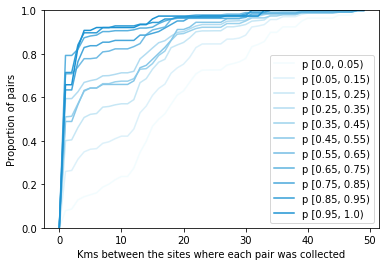

{0: [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49],
  [0.0,
   0.07920097723630636,
   0.08620633110034777,
   0.12852238833462346,
   0.14307580544946716,
   0.15192178874857415,
   0.1608522334423095,
   0.18707480089798637,
   0.2009642076869753,
   0.22118058160655457,
   0.23607364135086117,
   0.23607364135086117,
   0.27468732436634863,
   0.3470648991472544,
   0.39779609671548505,
   0.46689719835264337,
   0.49961071383805605,
   0.5241063153312256,
   0.5680356750554503,
   0.6099559318180899,
   0.6297661722230733,
   0.6699900128893479,
   0.7080376248557305,
   0.7251823894398098,
   0.7254249913179976,
   0.725669390247135,
   0.7259115428625853,
   0.7484546484990806,
   0.7552385158

In [93]:
final_plot(df_pares_abejas)

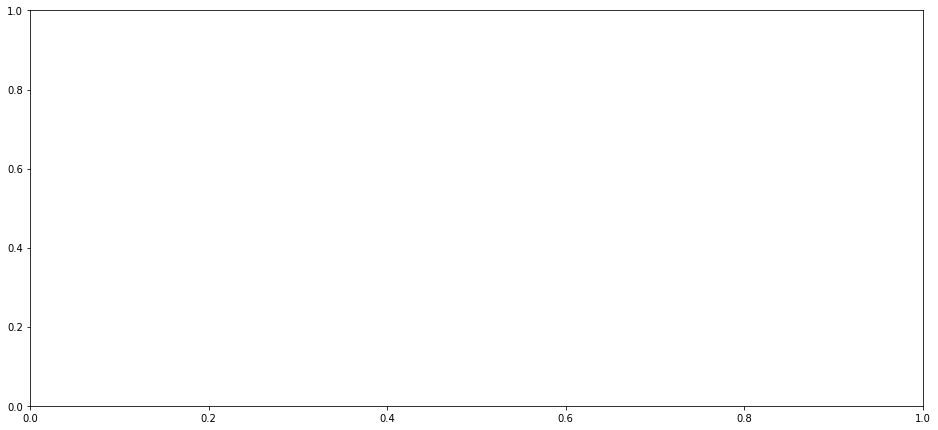

In [94]:
dfPC2018=df[df.Cluster=='PC2018'].sort_values(aleles)

f=plt.figure(figsize=(16,16))
ax=plt.subplot(int(str("211")))    

k=1

op=0.95
sitios=list(set(dfPC2018.Site))
j=0
gemels=[]
old_probs=[]
while j<len(dfPC2018):
        if True:
            i=j+1
            flag=len(aleles)
            while flag==len(aleles) and i<len(dfPC2018):
                flag=0
                while flag<len(aleles) and dfPC2018.iloc[j][aleles[flag]]==dfPC2018.iloc[i][aleles[flag]] : flag+=1
                if flag==len(aleles):
                    gemels.append(([dfPC2018.iloc[j]["Site"], 
                                                  dfPC2018.iloc[i]["Site"]]))
                    old_probs.append(dfPC2018.iloc[j]["Old prob"])
                i+=1
        j+=1


distances=[]
for g in gemels:
        d=euclidean_dist(information[g[0]]["utm_xy"], 
                             information[g[1]]["utm_xy"])
        distances.append(d)



In [103]:
import numpy as np
import statsmodels.api as sm


mod = sm.OLS(distances, pd.DataFrame([{"Constant":1, "heterozygous pair": int(i>=0.95)} for i in old_probs]))

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     194.5
Date:                Sun, 15 Mar 2020   Prob (F-statistic):           2.84e-43
Time:                        19:47:46   Log-Likelihood:                -17700.
No. Observations:                4347   AIC:                         3.540e+04
Df Residuals:                    4345   BIC:                         3.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             14.5030      0.22

In [ ]:
np.sum